In [1]:
#initialization of libraries and settings

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Set the figure size for all plots
plt.rcParams['figure.figsize'] = [10, 10]  # width, height in inches

This process is the import procedure for the tetracycline data from the .csv file used to store data uploaded from the literature. The data is cleaned during the upload. Since some information is stored in scientific numerals, it must be converted into floating-point numeration. Removal of the +/- values also takes place here. In order to meet auditing requirements, all processes are documented in the output.

In [3]:
#extract data with specific formatting from a CSV file
def extract_number(value, changes):
    original_value = value
    try:
        # Check if the value is already a number
        if isinstance(value, (int, float)):
            return value

        # Remove commas from the value
        if isinstance(value, str):
            value = value.replace(",", "")

        # Handle scientific notation in the format '5.7±1.1×10^4'
        match = re.match(r"^(.*?)(?:±.*?)?×10\^([\d+-]+)$", value)
        if match:
            base = match.group(1)
            exponent = match.group(2)
            if not base:
                changes.append((original_value, None))  # Record the change
                return None

            new_value = float(base) * (10 ** float(exponent))
            changes.append((original_value, new_value))  # Record the change
            return new_value

        # Handle the '±' format
        if '±' in value:
            num_part = value.split('±')[0]
            new_value = float(num_part)
            changes.append((original_value, new_value))
            return new_value
        else:
            return float(value)

    except (ValueError, TypeError, AttributeError):
        changes.append((original_value, None))  # Record the change
        return None

# Initialize list to track changes
changes_made = []

# CSV upload of tetracycline measurements with changes made during import
df_meas = pd.read_csv(r"C:\Users\phosg\OneDrive\Documents\TetEMeasurements_NoFDA_USETHIS.csv", encoding='latin-1', usecols=range(7),
                 converters={'Amount': lambda x: extract_number(x, changes_made)})

# Print audit summary
print("Changes Made During Import:")
print("----------------------------")
if changes_made:
    for original, new in changes_made:
        if new is None:
            print(f"  '{original}' -> Could not parse")
        else:
            print(f"  '{original}' -> {new}")
else:
    print("  No changes made.")

print("\nDataFrame after import:")
print(df_meas)

Changes Made During Import:
----------------------------
  '231±0.08' -> 231.0
  '224±0.07' -> 224.0
  '256±0.05' -> 256.0
  '212±0.034' -> 212.0
  '234±0.075' -> 234.0
  '226±0.032' -> 226.0
  '196±0.065' -> 196.0
  '183±0.021' -> 183.0
  '192±0.031' -> 192.0
  '175±0.021' -> 175.0
  '189±0.010' -> 189.0
  '194±0.031' -> 194.0
  '265±0.015' -> 265.0
  '247±0.021' -> 247.0
  '258±0.011' -> 258.0
  '231±0.09' -> 231.0
  '227±0.066' -> 227.0
  '218±0.050' -> 218.0
  '241±0.044' -> 241.0
  '235±0.005' -> 235.0
  '224±0.002' -> 224.0
  '267±0.016' -> 267.0
  '252±0.014' -> 252.0
  '249±0.002' -> 249.0
  '232±0.012' -> 232.0
  '241±0.022' -> 241.0
  '223±0.001' -> 223.0
  '265±0.013' -> 265.0
  '274±0.001' -> 274.0
  '248±0.014' -> 248.0
  '233±0.010' -> 233.0
  '241±0.070' -> 241.0
  '257±0.107' -> 257.0
  '287±0.032' -> 287.0
  '276±0.064' -> 276.0
  '295±0.062' -> 295.0
  '237±0.054' -> 237.0
  '241±0.027' -> 241.0
  '255±0.069' -> 255.0
  '225±0.063' -> 225.0
  '246±0.037' -> 246.0
  '2

The first ten lines of data in the output format are presented here.

In [10]:
#show data

df_meas.head(10)

,Compartment,Antimicrobial,Amount,Units,Geolocation,Country,Year
0,Tissue,Oxytetracycline,231.0,ppb,Hamadan Province,Iran,2016
1,Tissue,Oxytetracycline,224.0,ppb,Hamadan Province,Iran,2016
2,Tissue,Oxytetracycline,256.0,ppb,Hamadan Province,Iran,2016
3,Tissue,Oxytetracycline,212.0,ppb,Hamadan Province,Iran,2016
4,Tissue,Oxytetracycline,234.0,ppb,Hamadan Province,Iran,2016
5,Tissue,Oxytetracycline,226.0,ppb,Hamadan Province,Iran,2016
6,Tissue,Oxytetracycline,196.0,ppb,Hamadan Province,Iran,2016
7,Tissue,Oxytetracycline,183.0,ppb,Hamadan Province,Iran,2016
8,Tissue,Oxytetracycline,192.0,ppb,Hamadan Province,Iran,2016
9,Tissue,Oxytetracycline,175.0,ppb,Hamadan Province,Iran,2016


To standardize the concentrations, the numbers are converted to nanograms per gram, again with auditing features to indicate where deviations from the expected output might be noted. Each compartment is handled differently, as the original volumes have different characteristics. Tissue concentrations have an assumed density, aquatic concentrations have a liquid component and assume a density of water, and sedimentary concentrations are an approximation, as dry and wet weight factors will not be taken into account.

In [13]:
# Convert amounts to ng/g and provide audit log

# Initialize list to track conversion changes
conversion_changes = []

# Define the conversion function
def convert_to_ng_g(row):
    original_amount = row['Amount']
    original_unit = row['Units']
    compartment = row['Compartment']
    converted_amount = original_amount # Default to original amount
    converted_unit = 'ng/g' # Target unit

    change_made = False
    warning_note = None # To add specific assumption warnings to the log

    # Handle potential NaN or non-numeric amounts before conversion
    if pd.isna(original_amount) or not isinstance(original_amount, (int, float)):
         log_entry = {
            'Original Amount': original_amount, 'Original Unit': original_unit, 'Compartment': compartment,
            'Converted Amount': 'Error/Invalid Input Amount', 'Converted Unit': 'N/A', 'Note': 'Invalid input' }
         conversion_changes.append(log_entry)
         return pd.Series([np.nan, None]) # Return NaN for amount, None for unit

    # Tissue Conversions (Assuming density 1 g/mL = 1 g/g for ppb)
    if compartment == 'Tissue':
        if original_unit == 'ppb':
            # 1 ppb = 1 ng/mL = 1 ng/g (assuming density 1 g/mL)
            converted_amount = original_amount
            if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/kg':
            # 1 ug/kg = 1000 ng / 1000 g = 1 ng/g
            converted_amount = original_amount
            if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/g': # <<<--- ADDED THIS CASE for Tissue
             # 1 ug/g = 1000 ng / 1 g = 1000 ng/g
             converted_amount = original_amount * 1000
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ng/g':
             converted_amount = original_amount # Already correct
        else:
             print(f"Warning: Unit '{original_unit}' not explicitly handled for Tissue compartment.")
             converted_amount = np.nan
             converted_unit = None
             change_made = True
             warning_note = f"Unhandled unit '{original_unit}'"

    # Aquatic Conversions (Assuming density 1 kg/L for L units)
    elif compartment == 'Aquatic':
        if original_unit == 'ng/L':
            # 1 ng/L = 1 ng / 1000 g = 0.001 ng/g
            converted_amount = original_amount * 0.001
            if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/L':
             # 1 ug/L = 1000 ng / 1000 g = 1 ng/g
             converted_amount = original_amount
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'mg/L':
             # 1 mg/L = 1,000,000 ng / 1000 g = 1000 ng/g
             converted_amount = original_amount * 1000
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ng/g':
             converted_amount = original_amount # Already correct
        else:
             print(f"Warning: Unit '{original_unit}' not explicitly handled for Aquatic compartment.")
             converted_amount = np.nan
             converted_unit = None
             change_made = True
             warning_note = f"Unhandled unit '{original_unit}'"

    # Sediment Conversions (Assuming density 1 kg/L for ng/L unit)
    elif compartment == 'Sediment':
        if original_unit == 'ng/g':
            converted_amount = original_amount # Already correct
        elif original_unit == 'mg/kg':
             # 1 mg/kg = 1,000,000 ng / 1000 g = 1000 ng/g
             converted_amount = original_amount * 1000
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/kg':
             # 1 ug/kg = 1000 ng / 1000 g = 1 ng/g
             converted_amount = original_amount
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ng/kg':
             # 1 ng/kg = 1 ng / 1000 g = 0.001 ng/g
             converted_amount = original_amount * 0.001
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ng/L': # <<<--- ADDED THIS CASE for Sediment
             # 1 ng/L = 1 ng / 1000 g = 0.001 ng/g (ASSUMES DENSITY 1 kg/L for measurement context)
             converted_amount = original_amount * 0.001
             warning_note = "Assumed 1 kg/L density for ng/L to ng/g conversion"
             print(f"Note: Applied 0.001 factor for ng/L in Sediment (Row Index: {row.name}), assuming density 1 kg/L.") # Print note during run
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/g': # <<<--- ADDED THIS CASE for Sediment
             # 1 ug/g = 1000 ng / 1 g = 1000 ng/g
             converted_amount = original_amount * 1000
             if original_unit != converted_unit: change_made = True
        else:
             print(f"Warning: Unit '{original_unit}' not explicitly handled for Sediment compartment.")
             converted_amount = np.nan
             converted_unit = None
             change_made = True
             warning_note = f"Unhandled unit '{original_unit}'"

    else:
         print(f"Warning: Compartment '{compartment}' not recognized.")
         converted_amount = np.nan
         converted_unit = None
         change_made = True
         warning_note = f"Unrecognized compartment '{compartment}'"

    # Log the change/error status
    log_entry = {
            'Original Amount': original_amount, 'Original Unit': original_unit, 'Compartment': compartment,
            'Converted Amount': converted_amount if not pd.isna(converted_amount) else 'Error/Unhandled/Invalid',
            'Converted Unit': converted_unit if converted_unit is not None else 'N/A',
            'Note': warning_note if warning_note else '' # Add note if applicable
        }
    # Log only if a change was made or an error/warning occurred
    if change_made or (original_unit != converted_unit and converted_unit == 'ng/g'):
        conversion_changes.append(log_entry)

    # Return NaN for amount if it ended up as None or NaN during conversion
    final_amount = converted_amount if not pd.isna(converted_amount) else np.nan
    final_unit = converted_unit if converted_unit is not None else None

    return pd.Series([final_amount, final_unit])


# Apply the conversion function
df_meas[['Amount_ng_g', 'Units_ng_g']] = df_meas.apply(convert_to_ng_g, axis=1)

# --- Audit Log Display ---
print("\nUnit Conversions Log:")
print("----------------------")
if conversion_changes:
    df_changes = pd.DataFrame(conversion_changes)
    df_changes['Converted Amount'] = pd.to_numeric(df_changes['Converted Amount'], errors='coerce').fillna(df_changes['Converted Amount']) # Keep strings for errors

    # Filter for successful and error logs
    df_success = df_changes[~df_changes['Converted Amount'].astype(str).str.contains('Error/Unhandled/Invalid', na=False)]
    df_errors = df_changes[df_changes['Converted Amount'].astype(str).str.contains('Error/Unhandled/Invalid', na=False)]

    print(f"Total rows processed where logging occurred: {len(df_changes)}")
    print(f"  Successfully converted/relabeled: {len(df_success)}")
    print(f"  Errors or unhandled units/compartments/invalid input: {len(df_errors)}")

    # Display a sample of successful conversions if any
    if not df_success.empty:
        print("\nSample of successful conversions/relabelings (first 10):")
        # Select columns to display in log, including Note
        print(df_success[['Original Amount', 'Original Unit', 'Compartment', 'Converted Amount', 'Converted Unit', 'Note']].head(10).to_markdown(index=False))
    # Display a sample of errors if any
    if not df_errors.empty:
         print("\nSample of errors/unhandled/invalid (first 10):")
         print(df_errors[['Original Amount', 'Original Unit', 'Compartment', 'Converted Amount', 'Converted Unit', 'Note']].head(10).to_markdown(index=False))

else:
    print("  No unit conversions or issues were logged.")

print("\nDataFrame after unit conversion (first 5 rows):")
# Display head with new columns, ensuring Amount_ng_g is included
print(df_meas[['Compartment', 'Antimicrobial', 'Amount', 'Units', 'Amount_ng_g', 'Units_ng_g', 'Geolocation', 'Country', 'Year']].head().to_markdown(index=False))

# Check for any remaining nulls (NaN) in the new amount column
print(f"\nNaN values in 'Amount_ng_g' after conversion: {df_meas['Amount_ng_g'].isnull().sum()}")

Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 312), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 313), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 314), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 315), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 316), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 317), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 318), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 319), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 320), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 321), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 322), assuming density 1 kg/L.

Statistics of the dataset.

In [16]:
# statistical makeup of the TC measurements
print(df_meas.describe())

             Amount         Year   Amount_ng_g
count  9.600000e+02   960.000000  9.600000e+02
mean   6.367139e+03  2010.329167  7.647132e+05
std    1.063423e+05     7.445596  1.398527e+07
min    0.000000e+00  1987.000000  0.000000e+00
25%    0.000000e+00  2007.750000  0.000000e+00
50%    9.183500e-01  2012.000000  8.665000e-03
75%    3.822000e+01  2017.000000  6.047500e+00
max    2.400000e+06  2021.000000  3.800000e+08


Variable makeup of the data.These are the categories of the dataset.

In [19]:
#variables in dataset
print(df_meas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Compartment    960 non-null    object 
 1   Antimicrobial  960 non-null    object 
 2   Amount         960 non-null    float64
 3   Units          960 non-null    object 
 4   Geolocation    901 non-null    object 
 5   Country        960 non-null    object 
 6   Year           960 non-null    int64  
 7   Amount_ng_g    960 non-null    float64
 8   Units_ng_g     960 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 67.6+ KB
None


Identify non-existent data.

In [22]:
# Count NaN values per column
print(df_meas.isnull().sum())

# Count total NaN values in the DataFrame
print(df_meas.isnull().sum().sum())

Compartment       0
Antimicrobial     0
Amount            0
Units             0
Geolocation      59
Country           0
Year              0
Amount_ng_g       0
Units_ng_g        0
dtype: int64
59


In [74]:
# Count occurrences of each environmental compartment
compartment_counts = df_meas['Compartment'].value_counts()

print(compartment_counts)

Compartment
Tissue      1389
Aquatic      620
Sediment     251
Name: count, dtype: int64


In [76]:
# Clear leading and trailing spaces in the Country variable
df_meas['Country'] = df_meas['Country'].str.strip()

# Replace 'USA' with 'United States'
df_meas['Country'] = df_meas['Country'].replace('USA', 'United States')

# Count occurrences of each Country
country_counts = df_meas['Country'].value_counts()

print(country_counts)

Country
China                      1217
United States               272
Japan                       192
Vietnam                     113
Taiwan                       88
India                        60
Iran                         45
Italy                        36
Indonesia                    33
Ireland                      21
Ecuador                      20
Thailand                     19
Mexico                       18
Finland                      15
Pakistan                     11
Ghana                        11
Chile                        10
Brazil                        9
Colombia                      8
Canada                        8
Romania                       8
Malaysia                      6
Philippines                   5
Bangladesh                    4
Norway                        4
Turkey                        3
Hong Kong SAR                 3
Costa Rica                    2
Korea (the Republic of)       2
Nicaragua                     2
Belize                        2


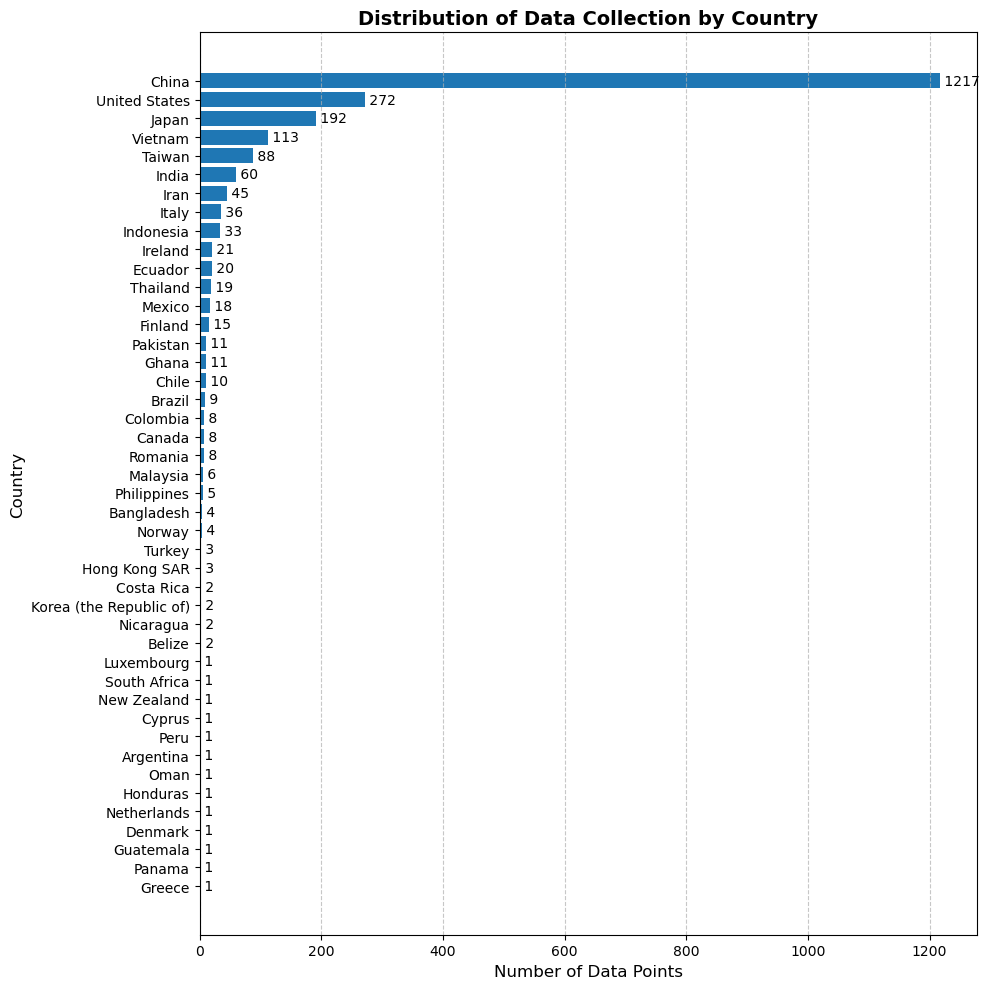

In [78]:
# Create a horizontal bar graph
plt.barh(country_counts.index, country_counts.values)

# Customize plot for data collection totals
plt.xlabel("Number of Data Points", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.title("Distribution of Data Collection by Country", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add value labels to the bars
for index, value in enumerate(country_counts.values):
    plt.text(value, index, f" {value}", va='center', fontsize=10, color="black")

# Invert y-axis to show the highest count at the top
plt.gca().invert_yaxis()

# Add gridlines (optional)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Save and show the plot
plt.savefig("country_distribution.png", dpi=300)

plt.show()

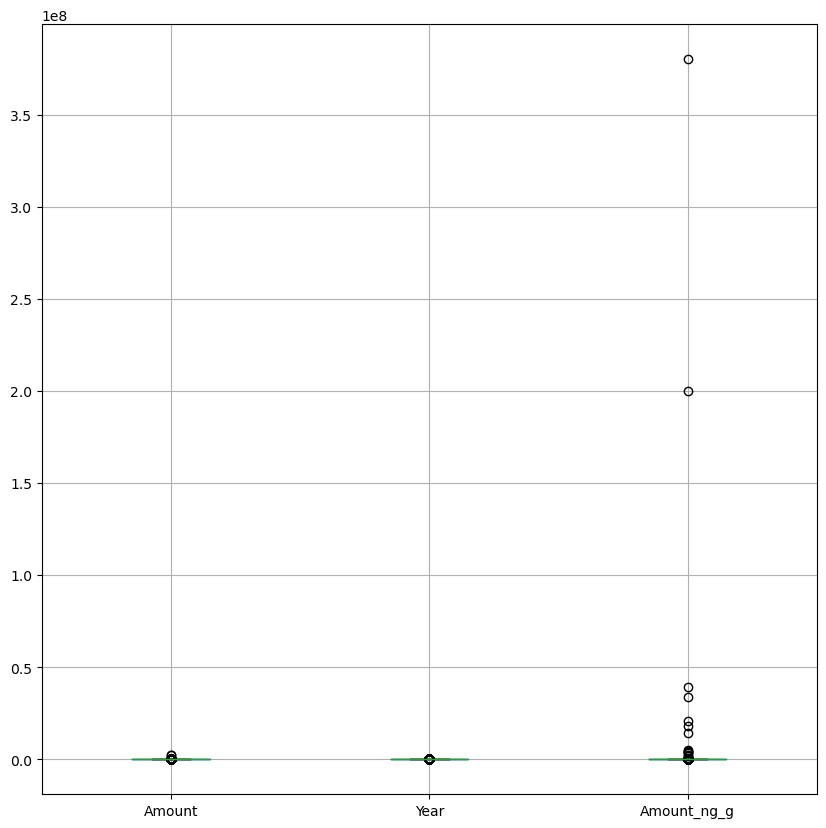

In [79]:
# Create box plots for all numerical columns
df_meas.boxplot()
plt.show()

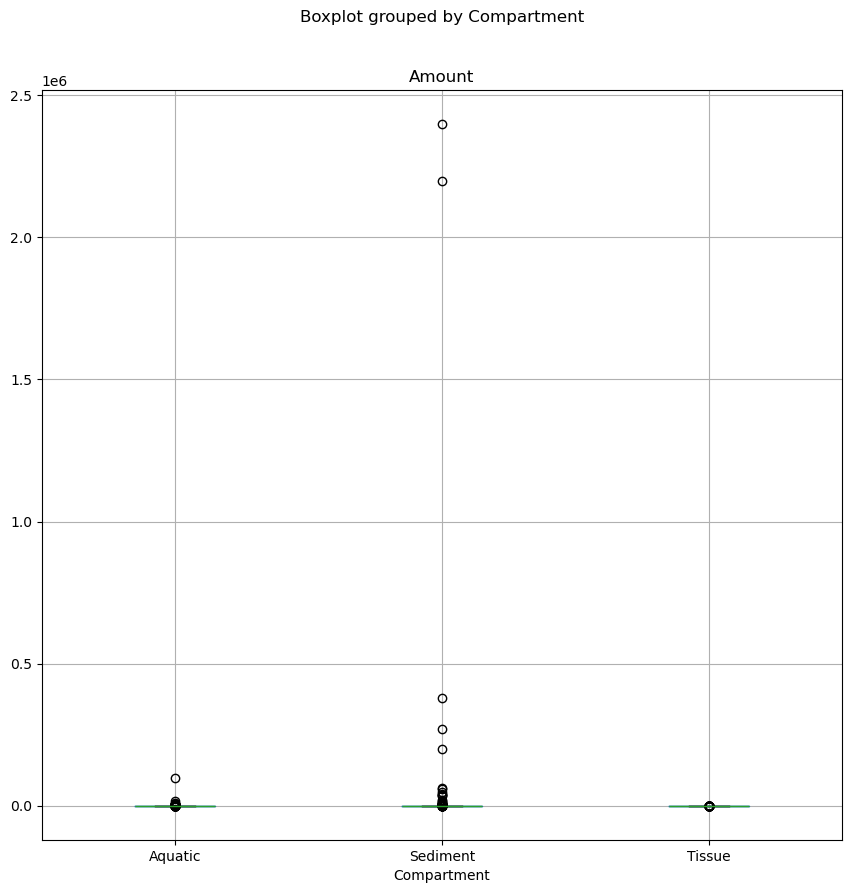

In [82]:
# Box plots grouped by a categorical column

df_meas.boxplot(column=['Amount'], by='Compartment')
plt.show()

In [84]:
# Initialize Nominatim geolocator
geolocator = Nominatim(user_agent="AMR_Dissertation/Ch3 (phosgenefreddie@gmail.com)")


# Add a delay to the geolocator to prevent request timeouts
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)

# Geocode and add latitude/longitude columns
df_meas['latitude'] = None
df_meas['longitude'] = None

for index, row in df_meas.iterrows():
    try:
        # Geocode using both 'Geolocation' and 'Country'
        if pd.isna(row['Geolocation']):
            print(f"Skipping row index {index} due to missing Geolocation.")
            continue # Skip to the next iteration of the loop
        location = geocode(f"{row['Geolocation']}, {row['Country']}")

        if location:
            df_meas.at[index, 'latitude'] = location.latitude
            df_meas.at[index, 'longitude'] = location.longitude
        else:
            print(f"Could not geocode: {row['Geolocation']}, {row['Country']}")

    except Exception as e:
        print(f"Error geocoding ({row['Geolocation']}, {row['Country']}): {e}")

# Print or save the updated DataFrame
head(df_meas)

# Save the DataFrame to a CSV file

df_meas.to_csv(r"AMRgeocoding.csv", index=False)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Colorado, United States',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\n

Skipping row index 225 due to missing Geolocation.
Skipping row index 226 due to missing Geolocation.
Skipping row index 227 due to missing Geolocation.
Skipping row index 228 due to missing Geolocation.
Skipping row index 229 due to missing Geolocation.
Skipping row index 230 due to missing Geolocation.
Skipping row index 231 due to missing Geolocation.
Skipping row index 232 due to missing Geolocation.
Skipping row index 233 due to missing Geolocation.
Skipping row index 234 due to missing Geolocation.
Skipping row index 235 due to missing Geolocation.
Skipping row index 236 due to missing Geolocation.
Skipping row index 237 due to missing Geolocation.
Skipping row index 238 due to missing Geolocation.
Skipping row index 239 due to missing Geolocation.
Skipping row index 240 due to missing Geolocation.
Skipping row index 241 due to missing Geolocation.
Skipping row index 242 due to missing Geolocation.
Skipping row index 243 due to missing Geolocation.
Skipping row index 244 due to m

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Guangdong, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\

Skipping row index 446 due to missing Geolocation.
Skipping row index 447 due to missing Geolocation.
Skipping row index 448 due to missing Geolocation.
Skipping row index 449 due to missing Geolocation.
Skipping row index 450 due to missing Geolocation.
Skipping row index 451 due to missing Geolocation.
Skipping row index 452 due to missing Geolocation.
Skipping row index 453 due to missing Geolocation.
Skipping row index 454 due to missing Geolocation.
Skipping row index 455 due to missing Geolocation.
Skipping row index 456 due to missing Geolocation.


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Hebei Province, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new

Could not geocode: New Jersey, Taiwan


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Guangdong, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\

Could not geocode: Nelson, New Zealand, New Zealand
Could not geocode: Kaohsiung, China
Could not geocode: Jiangxi, Thailand
Could not geocode: Gyeongsang Province, Korea (the Republic of)
Could not geocode: Gyeongsang Province, Korea (the Republic of)


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Jiangxi, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\li

Could not geocode: Taiwan, Taiwan
Could not geocode: South Jeolla Province, Oman


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Guangdong, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\

Could not geocode: Shanghai, China


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Shanghai, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\l

Could not geocode: Shanghai, China


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Shanghai, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\l

Could not geocode: Shanghai, China


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Shanghai, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\l

Could not geocode: Mu?la, Turkey


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Guangdong, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\

Could not geocode: Cundinamarca Department, Colombia


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Maine, United States',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_

Could not geocode: Sóc Tr?ng, Vietnam
Could not geocode: Chauthanh, Vietnam
Could not geocode: Cundinamarca Department, Colombia
Could not geocode: Huila Department, Colombia


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Guangdong, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\

Could not geocode: Parana, Brazil
Could not geocode: Andhra Pradesh, Ecuador


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Ca Mau, Vietnam',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\l

Could not geocode: Huila Department, Colombia
Could not geocode: Chiyai, Taiwan
Could not geocode: Chiyai, Taiwan


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Fujian, China',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_env\lib

Could not geocode: Parana, Brazil


RateLimiter caught an error, retrying (0/2 tries). Called with (*('East Java, Indonesia',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\new_

Could not geocode: Chinandega Department, Nicaragua


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Los Lagos Region, Chile',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs\n

Could not geocode: Massachusetts, Colombia
Could not geocode: Maine, Ecuador
Could not geocode: Pedernaleses Canton, Ecuador


RateLimiter caught an error, retrying (0/2 tries). Called with (*('South Sulawesi, Indonesia',), **{}).
Traceback (most recent call last):
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\geopy\adapters.py", line 298, in get_text
    page = self.urlopen(req, timeout=timeout)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 517, in open
    response = self._open(req, data)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 534, in _open
    result = self._call_chain(self.handle_open, protocol, protocol +
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 494, in _call_chain
    result = func(*args)
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1389, in https_open
    return self.do_open(http.client.HTTPSConnection, req,
  File "C:\Users\phosg\anaconda3\envs\new_env\lib\urllib\request.py", line 1350, in do_open
    r = h.getresponse()
  File "C:\Users\phosg\anaconda3\envs

NameError: name 'head' is not defined

In [86]:
# Prepare data for Gudhi TDA - Create a spatial point cloud

import numpy as np # Ensure numpy is imported
import pandas as pd # Ensure pandas is imported

print("Preparing data for TDA...")

# Select relevant columns for the point cloud

point_cloud_columns = ['longitude', 'latitude']
df_tda_input = df_meas[point_cloud_columns].copy()

# --- Handle Missing Coordinate Values ---
initial_rows = len(df_tda_input)
# Drop rows where either longitude or latitude is missing (NaN)
# These might be rows that failed geocoding earlier
df_tda_input.dropna(subset=point_cloud_columns, inplace=True)
final_rows = len(df_tda_input)

if initial_rows > final_rows:
    print(f"Dropped {initial_rows - final_rows} rows with missing coordinate data.")
else:
    print("No rows dropped due to missing coordinates.")

# Convert to NumPy array as input for point cloud
point_cloud = df_tda_input.to_numpy()

print(f"\nCreated point cloud with shape: {point_cloud.shape}")
print("(Shape represents: number of points x number of dimensions)")

# Display the first 5 points as a sample
print("\nSample points (first 5):")
print(point_cloud[:5])


Preparing data for TDA...
Dropped 86 rows with missing coordinate data.

Created point cloud with shape: (2174, 2)
(Shape represents: number of points x number of dimensions)

Sample points (first 5):
[[48.6563818 34.9726302]
 [48.6563818 34.9726302]
 [48.6563818 34.9726302]
 [48.6563818 34.9726302]
 [48.6563818 34.9726302]]


In [93]:
# Build Alpha Complex

import gudhi as gd # Ensure gudhi is imported
import matplotlib.pyplot as plt # For plotting

print("Building Alpha Complex...")

# Create an Alpha Complex object from the point cloud suitable for point clouds in Euclidean space (lat/long)

alpha_complex = gd.AlphaComplex(points=point_cloud)

# Create the simplex tree (the data structure used for persistence)

# simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=1.0)
# Alternatively, to compute the full complex (potentially slow/memory intensive):
simplex_tree = alpha_complex.create_simplex_tree()

print(f"Simplex tree created with {simplex_tree.num_simplices()} simplices.")

Building Alpha Complex...
Simplex tree created with 887 simplices.


Computing persistence diagram...
Persistence computation complete.
Plotting persistence diagram...


C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\gudhi\persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


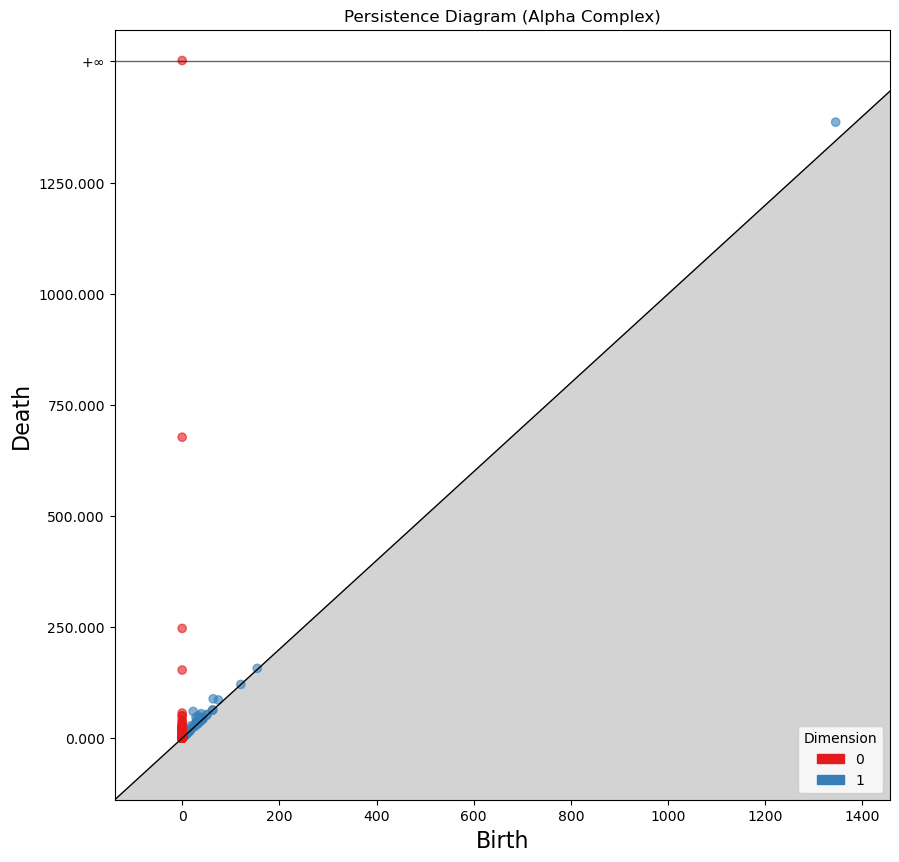

In [95]:
# Compute the persistence diagram
print("Computing persistence diagram...")

persistence_diagram = simplex_tree.persistence(homology_coeff_field=11, min_persistence=0.01) # Adjust min_persistence as needed

print("Persistence computation complete.")

# Plot the persistence diagram

print("Plotting persistence diagram...")
gd.plot_persistence_diagram(persistence_diagram, legend=True)
plt.title("Persistence Diagram (Alpha Complex)")
plt.show()

Plotting persistence barcode...


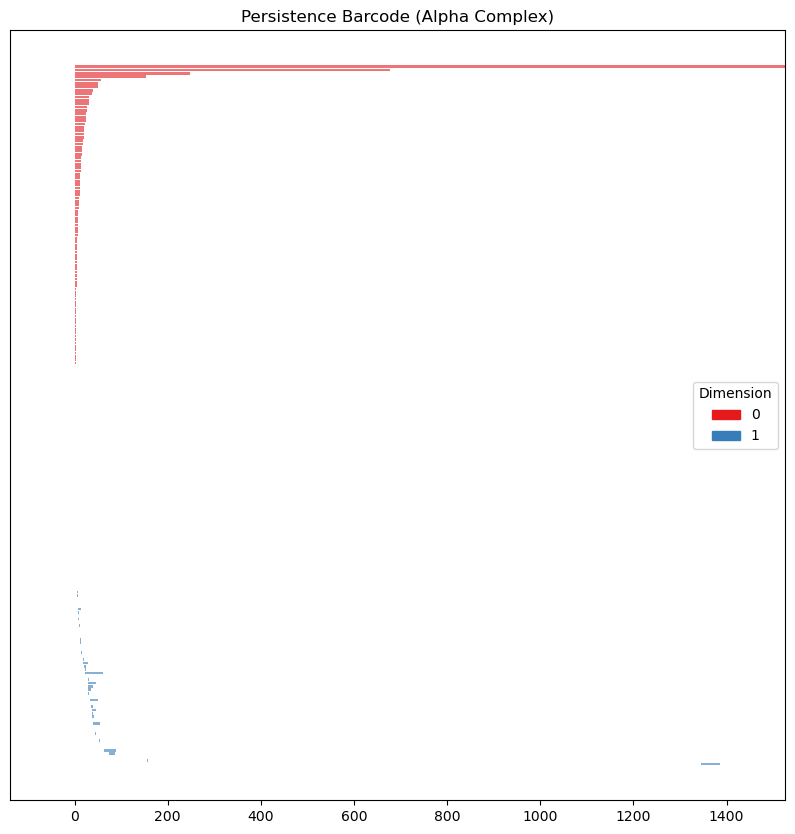

In [97]:
# Plot the persistence barcode

print("Plotting persistence barcode...")
gd.plot_persistence_barcode(persistence_diagram, legend=True)
plt.title("Persistence Barcode (Alpha Complex)")
plt.show()

In [101]:
# Print the persistence pairs (dimension, birth, death)

print("\nPersistence Pairs (dimension, birth, death):")
for point in persistence_diagram:
    print(point)


Persistence Pairs (dimension, birth, death):
(1, (1344.7978234679354, 1386.8606082880578))
(1, (22.691103379504696, 60.06873068339892))
(1, (63.82621711306416, 88.55919644488347))
(1, (28.449932336092893, 46.950680081411065))
(1, (33.552976452763815, 50.265818114615634))
(1, (38.89791199316879, 55.131538451672846))
(1, (74.52524539208869, 85.90893074203541))
(1, (18.82817148536209, 28.15124621309545))
(1, (36.95138745277791, 46.14581679503174))
(1, (29.390439297935124, 38.57311277179466))
(1, (29.743799927606307, 35.64092942394902))
(1, (7.39012571274675, 13.122837573203787))
(1, (34.840277513888935, 39.20919941400582))
(1, (37.661759577193735, 41.76419797541352))
(1, (28.023918936324556, 32.008342811005576))
(1, (10.679851878545026, 14.087979399399192))
(1, (21.739470008994772, 25.129732866678328))
(1, (10.884471573456853, 13.702074095012566))
(1, (154.51904800353316, 157.05998456562838))
(1, (9.227900048711145, 11.642451010217188))
(1, (51.39516464338253, 53.722159259548555))
(1, (2

In [103]:
# Prepare data for Gudhi TDA (Revised for 4D point cloud)

print("Preparing 4D data for TDA...")

# Select relevant columns for the 4D point cloud

point_cloud_columns = ['longitude', 'latitude', 'Year', 'Amount_ng_g']

# Create a temporary dataframe with the selected columns and the original index

df_tda_input_indexed = df_meas[point_cloud_columns].copy()
df_tda_input_indexed['original_index'] = df_meas.index # Store original index

# Detect and Handle Missing Values

initial_rows = len(df_tda_input_indexed)

# Drop rows where any of the selected columns have missing values

df_tda_input_indexed.dropna(subset=point_cloud_columns, inplace=True)
final_rows = len(df_tda_input_indexed)

if initial_rows > final_rows:
    print(f"Dropped {initial_rows - final_rows} rows with missing data in selected columns ({', '.join(point_cloud_columns)}).")
else:
    print("No rows dropped due to missing data in selected columns.")

# Create 4D Point Cloud
point_cloud_4d = df_tda_input_indexed[point_cloud_columns].to_numpy()

print(f"\nCreated 4D point cloud with shape: {point_cloud_4d.shape}")
print("(Shape represents: number of points x number of dimensions)")

# Display the first 5 points as a sample
print("\nSample points (first 5):")
print(point_cloud_4d[:5])

print("\nSample of index mapping DataFrame (first 5 rows):")
print(df_tda_input_indexed.head().to_markdown(index=False))

Preparing 4D data for TDA...
Dropped 86 rows with missing data in selected columns (longitude, latitude, Year, Amount_ng_g).

Created 4D point cloud with shape: (2174, 4)
(Shape represents: number of points x number of dimensions)

Sample points (first 5):
[[48.6563818 34.9726302 2016 231.0]
 [48.6563818 34.9726302 2016 224.0]
 [48.6563818 34.9726302 2016 256.0]
 [48.6563818 34.9726302 2016 212.0]
 [48.6563818 34.9726302 2016 234.0]]

Sample of index mapping DataFrame (first 5 rows):
|   longitude |   latitude |   Year |   Amount_ng_g |   original_index |
|------------:|-----------:|-------:|--------------:|-----------------:|
|     48.6564 |    34.9726 |   2016 |           231 |                0 |
|     48.6564 |    34.9726 |   2016 |           224 |                1 |
|     48.6564 |    34.9726 |   2016 |           256 |                2 |
|     48.6564 |    34.9726 |   2016 |           212 |                3 |
|     48.6564 |    34.9726 |   2016 |           234 |                4 |


In [113]:
# Scale the 4D data before TDA

from sklearn.preprocessing import StandardScaler

print("Scaling the 4D data...")

scaler = StandardScaler()
point_cloud_4d_scaled = scaler.fit_transform(point_cloud_4d)

print("Data scaled using StandardScaler.")
print("Sample scaled points (first 5):")
print(point_cloud_4d_scaled[:5])

Scaling the 4D data...
Data scaled using StandardScaler.
Sample scaled points (first 5):
[[-0.40376109  0.53691578  0.11062117 -0.03629946]
 [-0.40376109  0.53691578  0.11062117 -0.03630021]
 [-0.40376109  0.53691578  0.11062117 -0.03629677]
 [-0.40376109  0.53691578  0.11062117 -0.0363015 ]
 [-0.40376109  0.53691578  0.11062117 -0.03629914]]


In [115]:
print("Building Alpha Complex...")

# Create an Alpha Complex object from the point cloud suitable for point clouds in Euclidean space (lat/long)

alpha_complex = gd.AlphaComplex(points=point_cloud_4d_scaled)

# Create the simplex tree (the data structure used for persistence)

# simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=1.0)
# Alternatively, to compute the full complex (potentially slow/memory intensive):
simplex_tree = alpha_complex.create_simplex_tree()

print(f"Simplex tree created with {simplex_tree.num_simplices()} simplices.")

Building Alpha Complex...
Simplex tree created with 89113 simplices.


Computing persistence diagram...
Persistence computation complete.
Plotting persistence diagram...


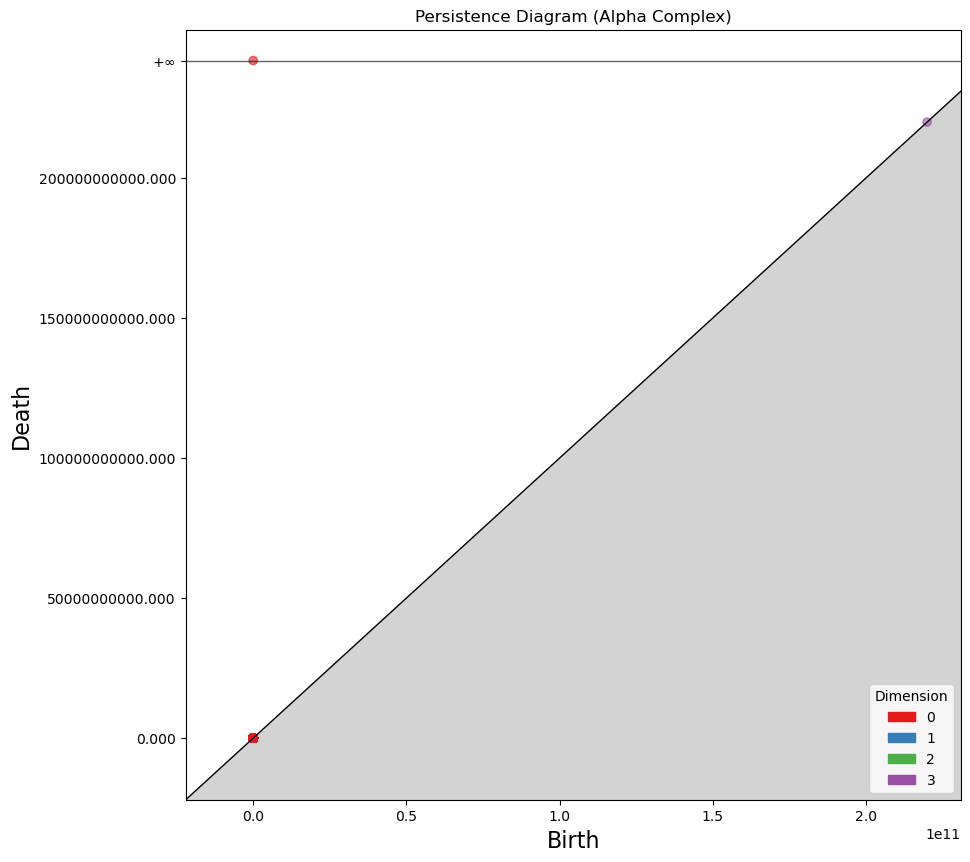

In [121]:
# Compute the persistence diagram
print("Computing persistence diagram...")

persistence_diagram = simplex_tree.persistence(homology_coeff_field=11, min_persistence=0.01) # Adjust min_persistence as needed

print("Persistence computation complete.")

# Plot the persistence diagram

print("Plotting persistence diagram...")
gd.plot_persistence_diagram(persistence_diagram, legend=True)
plt.title("Persistence Diagram (Alpha Complex)")
plt.show()

In [123]:
# Read the CSV file into a DataFrame
df_gene = pd.read_csv(r'C:\Users\phosg\OneDrive\Documents\Enterococcus2025USETHIS.csv', skiprows=1, names = ['Organism', 'Year', 'Region', 'Source', 'Type', 'Gene', 'computed'])

# Extract the year and convert to numeric
df_gene['Year'] = pd.to_datetime(df_gene['Year']).dt.year

# Split the 'Region' column into two columns to define both the region and the country
df_gene[['Nation', 'Region']] = df_gene['Region'].str.split(':', expand=True)

# Create a new column 'gene_present' based on the condition
df_gene['Present'] = (df_gene['Gene'].str.contains('tet\(', na=False) | df_gene['computed'].str.contains('tet\(', na=False)).astype('int8')

# Reorder columns and eliminate two unnecessary columns
df_gene = df_gene[['Organism', 'Year', 'Region', 'Nation', 'Source', 'Present']]

# Display the first 5 rows
df_gene.head()

,Organism,Year,Region,Nation,Source,Present
0,Enterococcus faecium,2017,Sao Vicente,Brazil,"seafood, marine bivalve",1
1,Enterococcus faecium,2019,Porto,Portugal,river water,0
2,Enterococcus faecium,2019,Porto,Portugal,supermaket trout,0
3,Enterococcus faecium,2019,Caima,Portugal,river water,1
4,Enterococcus faecium,2019,Kingston,Canada,Wastewater (Primary Effluent),1


In [111]:
# Print the column names and their data types
print(df_gene.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Organism  444 non-null    object
 1   Year      444 non-null    int32 
 2   Region    431 non-null    object
 3   Nation    444 non-null    object
 4   Source    444 non-null    object
 5   Present   444 non-null    int8  
dtypes: int32(1), int8(1), object(4)
memory usage: 16.2+ KB
None
